# Importing All Necessary Packages and Files 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
import theano
import theano.tensor as tt
import itertools
from IPython.core.pylabtools import figsize
pd.set_option('display.max_columns', 30)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/My Drive')

In [ ]:
df = pd.read_csv('/content/drive/My Drive/finalstockdata.csv')

In [ ]:
df.head(5)

,Date,MSFT,NVDA,UNH,JNJ,JPM,y
0,2000-01-03,-0.40625,-0.009115,0.078125,-0.46875,-1.250000,0
1,2000-01-04,-0.46875,-0.009114,-0.039062,-1.15625,0.166668,0
2,2000-01-05,1.34375,-0.003906,-0.023437,0.46875,0.125000,1
3,2000-01-06,-1.09375,-0.059896,0.234375,1.12500,0.875000,0
4,2000-01-07,1.40625,0.018229,0.476563,1.18750,0.083332,1


# Sampling our Posterior

In [ ]:
priors = {"Intercept": pm.Flat.dist(),
          "Regressor": pm.Normal.dist(mu=0, sigma=0.4)
          }

with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('y ~ MSFT + NVDA + UNH + JNJ + JPM', df, 
                            family = pm.glm.families.Binomial(), priors = priors)
    trace = pm.sample(1000, tune = 1000, init = 'adapt_diag')
    


The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [JPM, JNJ, UNH, NVDA, MSFT, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 39 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e407dd150>,
      dtype=object)

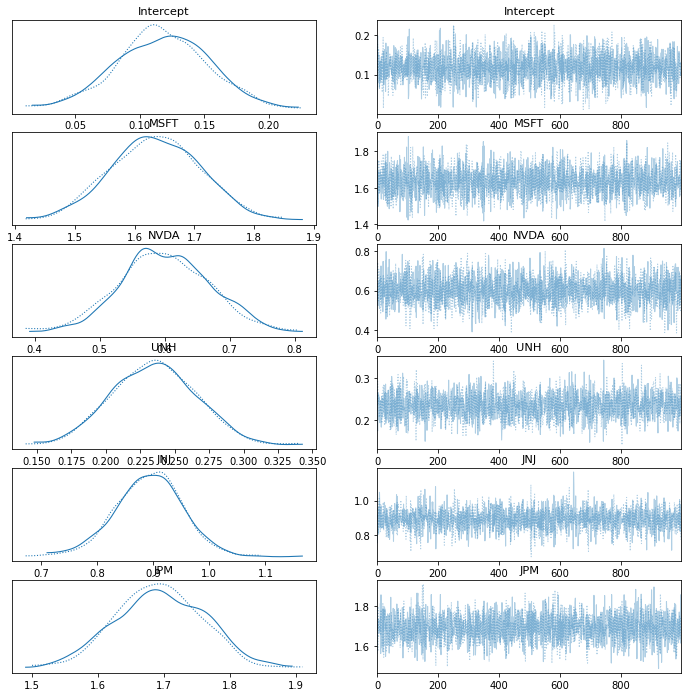

In [ ]:
az.plot_trace(trace, divergences=None)

### Obtaining our mean values 

First we compute a standard logistic regression to compair

In [ ]:
from sklearn.linear_model import LogisticRegression
##Define the model for the logistic regression
model = LogisticRegression(solver='liblinear', random_state=0)

X = df[['MSFT','NVDA','UNH','JNJ','JPM']].values
Y = df['y'].values
##Fit the logistic regression model
model.fit(X, Y)

LogisticRegression(random_state=0, solver='liblinear')

In [ ]:
logCof = model.coef_ 
logInt = b = model.intercept_[0]
Coefs = [logInt]

for c in range(len(logCof[0])): 
  Coefs.append(logCof[0][c])

In [ ]:
Coefs

[0.1185450248671061,
 1.6935301808917385,
 0.6159821289641793,
 0.23812405876918857,
 0.9126247240568616,
 1.7445299899313207]

Now lets find what the Bayes estimates are:

In [ ]:
names = ['Intercept','MSFT', 'NVDA', 'UNH', 'JNJ', 'JPM']

for i in range(len(names)): 
  be = np.mean(trace[names[i]])
  #coef = Coefs[i]
  print(f"{names[i]} Bayes-Estimate: {be}")


Intercept Bayes-Estimate: 0.11754411500445329
MSFT Bayes-Estimate: 1.6356786412822566
NVDA Bayes-Estimate: 0.6002748527062304
UNH Bayes-Estimate: 0.23520205594708388
JNJ Bayes-Estimate: 0.8922868423613136
JPM Bayes-Estimate: 1.6932975371613834


# Backtest Confusion Matrix with mean values

Confusion matrix
[[2074  569]
 [ 481 2484]]


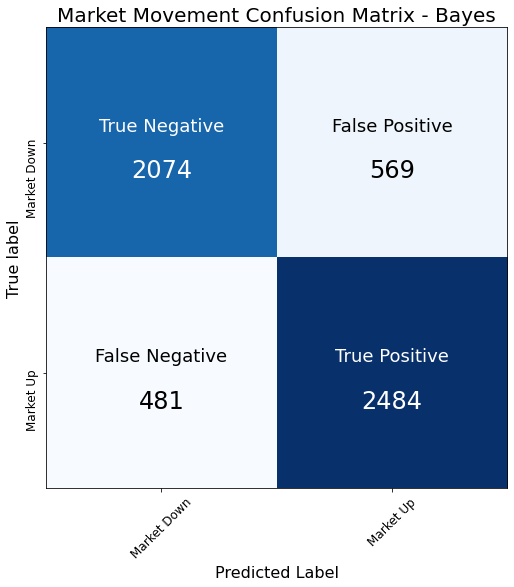

In [ ]:
ppc = pm.sample_posterior_predictive(trace, model=logistic_model, samples=500)
preds = np.rint(ppc['y'].mean(axis=0)).astype('int')

def plot_confusion_matrix(cm, classes = ['Market Down', 'Market Up'],
                          title='Market Movement Confusion Matrix - Bayes',
                          cmap=plt.cm.Blues):
    
    # Display the matrix in text form
    print('Confusion matrix')
    print(cm)
    figsize(8, 8)
    
    # Show the matrix using the imshow functionality
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20)
    
    # Tick marks show classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 12)
    plt.yticks(tick_marks, classes, rotation = 90, size = 12)

    # Formatting for text labels on plot
    fmt1 = 's'
    fmt2 = 'd'
    thresh = cm.max() / 2.
    
    # Four types of classifications
    types = [['True Negative', 'False Positive'],
             ['False Negative', 'True Positive']]
    
    # Add the actual numbers and the types onto the heatmap plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i - 0.05, format(types[i][j], fmt1),
                 horizontalalignment="center", size = 18,
                 color="white" if cm[i, j] > thresh else "black")
        
        plt.text(j, i + 0.15, format(cm[i, j], fmt2),
                 horizontalalignment="center", size = 24,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size = 16)
    plt.xlabel('Predicted Label', size = 16)
    
cm = confusion_matrix(df['y'], preds)
plot_confusion_matrix(cm)

In [ ]:
pred_ys = model.predict(X)

Confusion matrix
[[2088  555]
 [ 476 2489]]


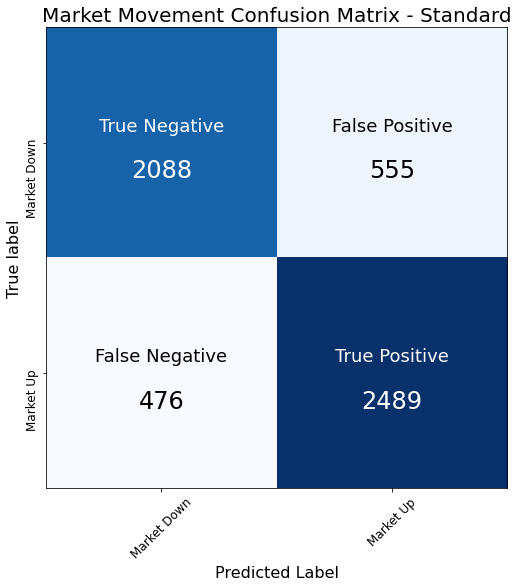

In [ ]:
cm2 = confusion_matrix(df['y'], pred_ys)
plot_confusion_matrix(cm2, title='Market Movement Confusion Matrix - Standard')

#Predictive Posterior Stuff

In [ ]:
names = ['Intercept','MSFT', 'NVDA', 'UNH', 'JNJ', 'JPM']
df2 = pd.DataFrame()
for name in names: 
  df2[name] = pd.DataFrame(trace[name])

In [ ]:
df2.to_csv('/content/drive/My Drive/trace.csv')

Predictive positorior 

In [ ]:
trace = pd.read_csv('/content/drive/My Drive/trace.csv')

In [ ]:
trace = df2

In [ ]:
def ppd(x, trace): 

  T = len(trace['Intercept'])

  #seprating our X values
  X1 = x[0]
  X2 = x[1]
  X3 = x[2]
  X4 = x[3]
  X5 = x[4]

  p_hat = []
  y_hat = []
  for t in range(T):
    #=log odds ratio
    eta = trace.iloc[t]['Intercept']+trace.iloc[t]['MSFT']*X1+trace.iloc[t]['NVDA']*X2+trace.iloc[t]['UNH']*X3+trace.iloc[t]['JNJ']*X4+trace.iloc[t]['JPM']*X5 
    np.exp(eta) #odds ratio
    p = np.exp(eta)/(1 + np.exp(eta))
    p_hat.append(p)
    y_hat.append(np.random.binomial(1,p))
  
  return p_hat, y_hat


Lets look at returns for APRl 22: 

MSFT: -7.65, NVDA: -7.88, UNH: -11.12, JNJ: -0.93, JPM: -3.75

SPY: 0

In [ ]:
x = [-7.65, -7.88, -11.12, -.93, -3.75]

p_hat, y_hat = ppd(x, trace)

In [ ]:
mean = np.mean(p_hat)

In [ ]:
np.round(mean, decimals=15)

3.408e-12

In [ ]:
i=0
for y in y_hat: 
  if y==1: 
    i = i+1

In [ ]:
import seaborn as sns

Text(0.73, 0.81, 'number of y_hat = 0 is 2000')

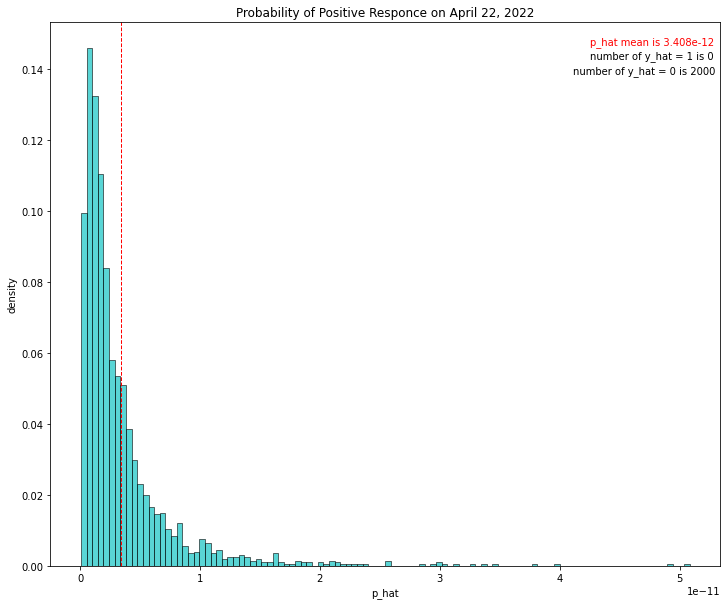

In [ ]:
plt.rcParams['figure.figsize'] = [12, 10]
fig, axs = plt.subplots()
sns.histplot(p_hat, stat='probability', ax=axs, color='c', edgecolor='k', alpha=0.65)
axs.set_title('Probability of Positive Responce on April 22, 2022')
axs.axvline(mean, color='r', linestyle='dashed', linewidth=1)
axs.set_xlabel('p_hat')
axs.set_ylabel('density')
fig.text(x=.75, y=.85, s=f'p_hat mean is {np.round(mean, decimals=15)}', c = 'r')
fig.text(x=.75, y=.83, s=f'number of y_hat = 1 is {i}', c = 'k')
fig.text(x=.73, y=.81, s=f'number of y_hat = 0 is {len(y_hat)-i}', c = 'k')

Now lets look at what happens when take thier average returns: 

In [ ]:
x = [df['MSFT'].mean(), df['NVDA'].mean(), df['UNH'].mean(), df['JNJ'].mean(), df['JPM'].mean()]

In [ ]:
x

[0.010690317514449571,
 -0.008314506314195377,
 0.04052535817558507,
 0.01688067549135488,
 -0.004928642604898666]

In [ ]:
p_hat, y_hat = ppd(x, trace)

In [ ]:
mean = np.mean(p_hat)

i=0
for y in y_hat: 
  if y==1: 
    i = i+1

Text(0.78, 0.79, 'y_true = unknown')

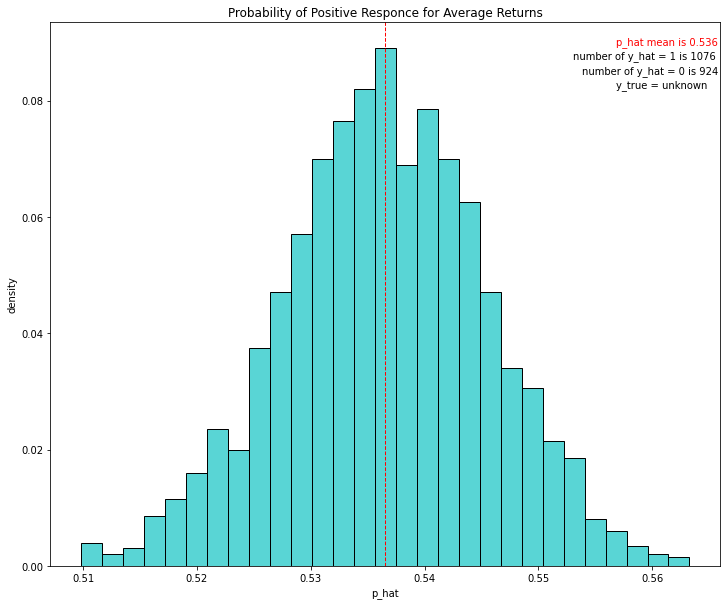

In [ ]:
plt.rcParams['figure.figsize'] = [12, 10]
fig, axs = plt.subplots()
sns.histplot(p_hat, stat='probability', ax=axs, color='c', edgecolor='k', alpha=0.65)
axs.set_title('Probability of Positive Responce for Average Returns')
axs.axvline(mean, color='r', linestyle='dashed', linewidth=1)
axs.set_xlabel('p_hat')
axs.set_ylabel('density')
fig.text(x=.78, y=.85, s=f'p_hat mean is {np.round(mean, decimals=3)}', c = 'r')
fig.text(x=.73, y=.83, s=f'number of y_hat = 1 is {i}', c = 'k')
fig.text(x=.74, y=.81, s=f'number of y_hat = 0 is {len(y_hat)-i}', c = 'k')
fig.text(x=.78, y=.79, s='y_true = unknown', c = 'k')

Now lets look at  June 17 2003: 

In [ ]:
df.loc[df.Date == '2003-06-17']

,Date,MSFT,NVDA,UNH,JNJ,JPM,y
866,2003-06-17,0.32,0.001667,0.289999,0.209999,0.099998,0


In [ ]:
temp = df.loc[df.Date == '2003-06-17']
x = [float(temp['MSFT'].values), 
     float(temp['NVDA'].values), 
     float(temp['UNH'].values), 
     float(temp['JNJ'].values), 
     float(temp['JPM'].values)]

In [ ]:
p_hat, y_hat = ppd(x, trace)

In [ ]:
mean = np.mean(p_hat)

i=0
for y in y_hat: 
  if y==1: 
    i = i+1

Text(0.83, 0.79, 'y_true = 0')

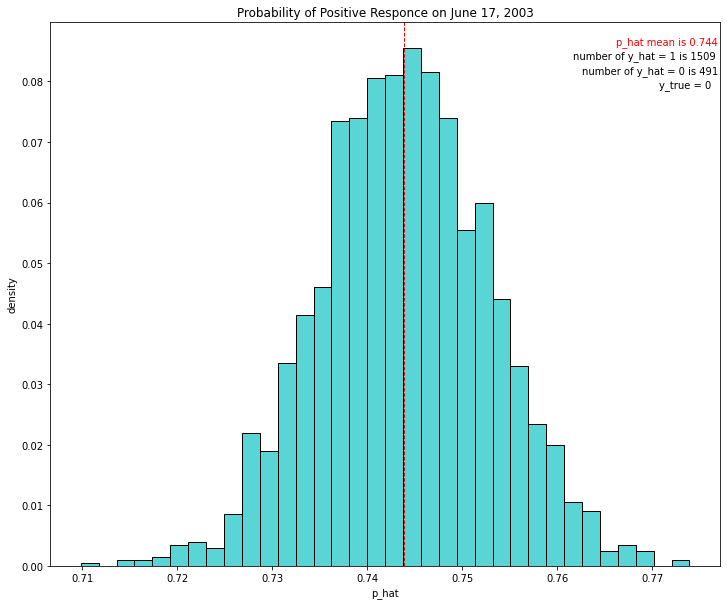

In [ ]:
plt.rcParams['figure.figsize'] = [12, 10]
fig, axs = plt.subplots()
sns.histplot(p_hat, stat='probability', ax=axs, color='c', edgecolor='k', alpha=0.65)
axs.set_title('Probability of Positive Responce on June 17, 2003')
axs.axvline(mean, color='r', linestyle='dashed', linewidth=1)
axs.set_xlabel('p_hat')
axs.set_ylabel('density')
fig.text(x=.78, y=.85, s=f'p_hat mean is {np.round(mean, decimals=3)}', c = 'r')
fig.text(x=.73, y=.83, s=f'number of y_hat = 1 is {i}', c = 'k')
fig.text(x=.74, y=.81, s=f'number of y_hat = 0 is {len(y_hat)-i}', c = 'k')
fig.text(x=.83, y=.79, s='y_true = 0', c = 'k')

Annimation? 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [ ]:
from matplotlib import rc
rc('animation', html='jshtml')

In [ ]:
from datetime import timedelta, date

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2000,1,3)
end_dt = date(2000,1,10)

dates = []
weekdays = [6,7]
for dt in daterange(start_dt, end_dt):
    if dt.isoweekday() not in weekdays:
        dates.append(dt.strftime("%Y-%m-%d"))

In [ ]:
df.loc[df.Date == '2020-04-03']

,Date,MSFT,NVDA,UNH,JNJ,JPM,y
5095,2020-04-03,-1.270004,-2.512501,-8.830002,1.789993,-1.949997,0


In [ ]:
df.loc[df.Date == '2021-04-01']

,Date,MSFT,NVDA,UNH,JNJ,JPM,y
5345,2021-04-01,3.880005,2.394989,-5.130005,0.229996,1.810013,1


In [ ]:
d = df.iloc[5095:5345]['Date']

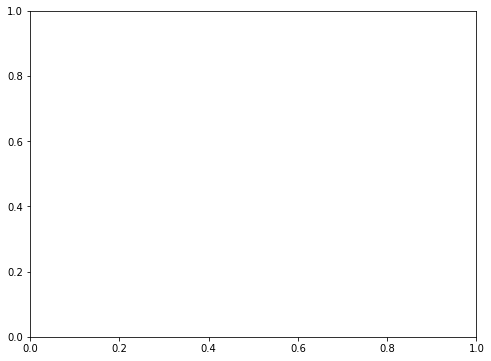

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes()

def func(frame):
    ax.clear()
    date = dates[frame]
    temp = df.loc[df.Date == date]
    x = [float(temp['MSFT'].values), 
         float(temp['NVDA'].values), 
         float(temp['UNH'].values), 
         float(temp['JNJ'].values), 
         float(temp['JPM'].values)]

    p_hat, y_hat = ppd(x, trace)
    mean = np.mean(p_hat)

    ax.set_title(f"Date: {date}. MSFT: {np.round(x[0], decimals=2)}. NVDA: {np.round(x[1], decimals=2)}. UNH: {np.round(x[2], decimals=2)}. JNJ: {np.round(x[3], decimals=2)}. JPM: {np.round(x[4], decimals=2)}")
    ax.set_xlabel('p_hat')
    ax.set_ylabel('prob')
    ax.axvline(mean, color='r', linestyle='dashed', linewidth=1)
    plot=sns.histplot(p_hat, stat='probability', ax=ax, color='c', edgecolor='k', alpha=0.65)
    return plot

In [ ]:
anim = animation.FuncAnimation(fig, func, frames=6, blit=False, repeat=True)

In [ ]:
anim

In [ ]:
dates = list(d.values)

In [ ]:
len(dates)

250

In [ ]:
anim2 = animation.FuncAnimation(fig, func, frames=250, blit=False, repeat=True)

In [ ]:
anim2

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# saving to m4 using ffmpeg writer
writervideo = animation.FFMpegWriter(fps=2)
anim2.save('/content/drive/My Drive/p-hat.mp4', writer=writervideo)